**Simon's Algorithm**

Simon's Algorithm Circuit:


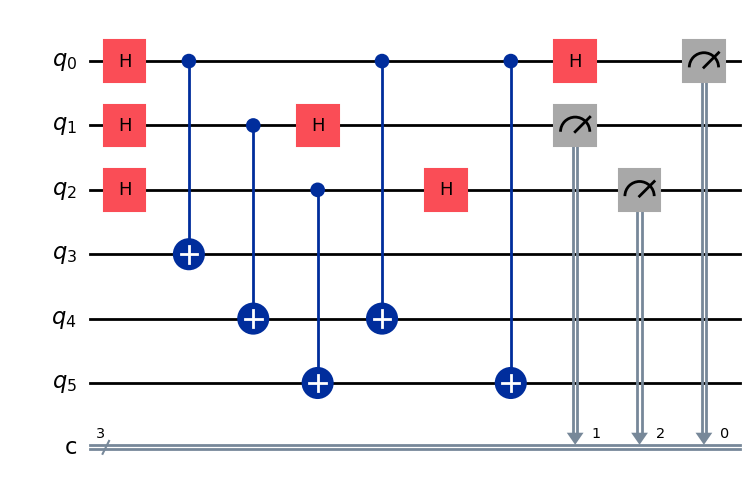


Measurement Results:

Secret string guess: 001
Actual secret: 110
Match: False


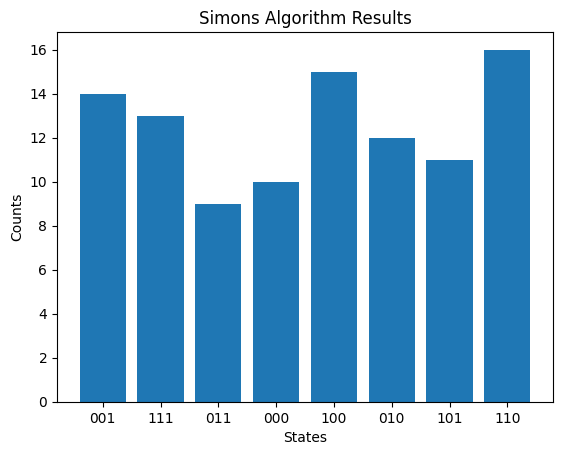

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

# Configuration
SECRET_STRING = '110'  # Secret bitstring to find
N = len(SECRET_STRING)  # Number of input qubits

def simon_oracle():
    """Creates Simon oracle for secret string '110'"""
    qc = QuantumCircuit(2*N)
    # Implement f(x) = f(x⊕s) mapping
    qc.cx(0, 3)
    qc.cx(1, 4)
    qc.cx(2, 5)
    qc.cx(0, 4)
    qc.cx(0, 5)
    return qc

# Full Simon's algorithm circuit
def simon_circuit():
    qc = QuantumCircuit(2*N, N)
    # Initialize input superposition
    for i in range(N):
        qc.h(i)
    # Apply oracle
    qc.compose(simon_oracle(), inplace=True)
    # Hadamard and measure
    for i in range(N):
        qc.h(i)
    qc.measure(range(N), range(N))
    return qc

# Create and display circuit
circuit = simon_circuit()
print("Simon's Algorithm Circuit:")
display(circuit.draw('mpl', fold=-1))

# Simulate
simulator = AerSimulator()
compiled = transpile(circuit, simulator)
job = simulator.run(compiled, shots=100)
counts = job.result().get_counts()

# Plot results
print("\nMeasurement Results:")
plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Counts')
plt.title('Simons Algorithm Results')

# Fixed classical post-processing with GF(2) Gaussian elimination
def gf2_solve_simon(measurements, n):
    """Solves y·s = 0 mod 2 using Gaussian elimination over GF(2)"""
    # Build matrix from measurements
    equations = []
    for bitstring in measurements:
        if int(bitstring, 2) != 0:
            equations.append([int(b) for b in bitstring])

    # Create coefficient matrix
    A = np.array(equations, dtype=int) if equations else np.zeros((0, n))

    # Gaussian elimination over GF(2)
    rows, cols = A.shape
    for r in range(min(rows, cols)):
        # Find pivot
        pivot = r
        while pivot < rows and A[pivot, r] == 0:
            pivot += 1
        if pivot >= rows:
            continue

        # Swap rows
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]

        # Eliminate
        for i in range(r+1, rows):
            if A[i, r] == 1:
                A[i] = (A[i] + A[r]) % 2

    # Back substitution
    s = np.zeros(n, dtype=int)
    free_vars = list(range(n))
    for r in range(min(rows, cols)-1, -1, -1):
        pivot_col = np.where(A[r] == 1)[0]
        if len(pivot_col) > 0:
            pivot_col = pivot_col[0]
            s[pivot_col] = 0  # Set pivot variable
            for c in range(pivot_col+1, n):
                s[pivot_col] = (s[pivot_col] + A[r, c]*s[c]) % 2
            s[pivot_col] = (s[pivot_col] + 1) % 2  # For non-trivial solution
            free_vars.remove(pivot_col)

    # Set free variables to 0
    for col in free_vars:
        s[col] = 0

    return ''.join(map(str, s))

# Find secret string
secret_guess = gf2_solve_simon(counts.keys(), N)
print(f"\nSecret string guess: {secret_guess}")
print(f"Actual secret: {SECRET_STRING}")
print("Match:", secret_guess == SECRET_STRING)
